In [1]:
from cloudvolume import CloudVolume
from skimage.transform import downscale_local_mean
import napari
from skimage import io
import random
import h5py
from skimage import measure
from brainlit.preprocessing import removeSmallCCs
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import subprocess
import tables
from scipy.stats import gaussian_kde, kstest
from scipy import stats
from tqdm import tqdm

%gui qt5

/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


# KDEs

<KeysViewHDF5 ['exported_data']>
<KeysViewHDF5 ['exported_data']>
Predicted Foreground p-val norm: 0.0, p-val poisson: 0.0
Predicted Background p-val norm: 0.0, p-val poisson: 1.2114465892878338e-14
<KeysViewHDF5 ['exported_data']>
<KeysViewHDF5 ['exported_data']>
Predicted Foreground p-val norm: 0.0, p-val poisson: 0.0
Predicted Background p-val norm: 0.0, p-val poisson: 2.180975182979957e-21
<KeysViewHDF5 ['exported_data']>
<KeysViewHDF5 ['exported_data']>
Predicted Foreground p-val norm: 0.0, p-val poisson: 0.0
Predicted Background p-val norm: 0.0, p-val poisson: 1.2839004629221358e-82


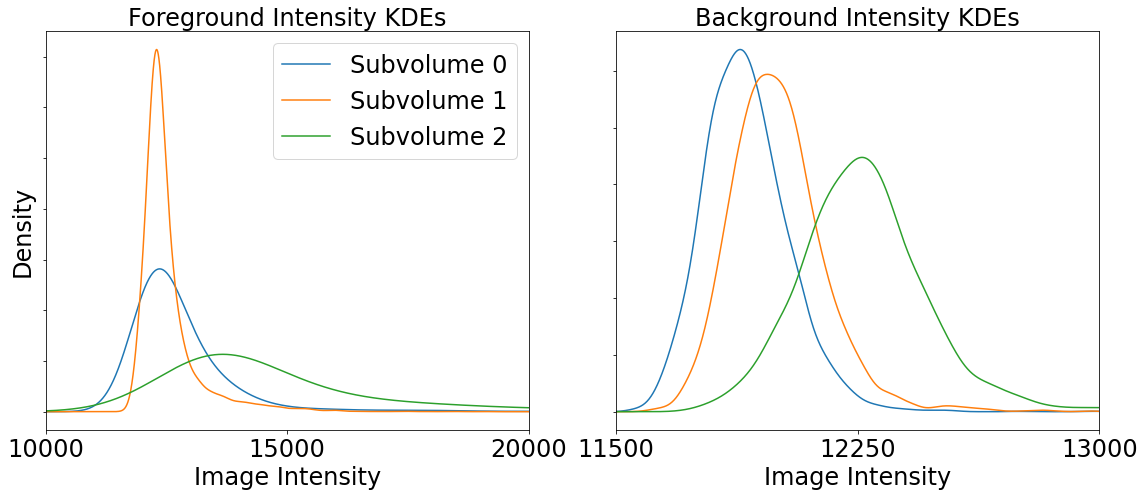

In [2]:
fig, axs = plt.subplots(1, 2)
ax_fg = axs[0]
ax_bg = axs[1]

colors = ["r", "b", "g"]

for i in range(10, 13):
    fname = (
        "/Users/thomasathey/Documents/mimlab/mouselight/octopus_experiment/ilastik_training/2018-08-01_"
        + str(i)
        + "_octopus.tif"
    )
    im = io.imread(fname)

    fname = (
        "/Users/thomasathey/Documents/mimlab/mouselight/octopus_experiment/ilastik_training/2018-08-01_"
        + str(i)
        + "_octopus_Labels.h5"
    )
    with h5py.File(fname, "r") as f:
        print(f.keys())
        labels = f["exported_data"]
        labels = labels[:, :, :, 0]

    fname = (
        "/Users/thomasathey/Documents/mimlab/mouselight/octopus_experiment/ilastik_training/2018-08-01_"
        + str(i)
        + "_octopus_Simple Segmentation.h5"
    )
    with h5py.File(fname, "r") as f:
        print(f.keys())
        pred = f["exported_data"]
        pred = pred[:, :, :, 0]

    fg_pred = im[pred == 2].flatten()
    np.random.shuffle(fg_pred)
    fg_pred = fg_pred[:5000]
    _, p_norm = kstest(fg_pred, "norm")
    _, p_poisson = kstest(fg_pred, "poisson", args=(np.mean(fg_pred),))
    print(f"Predicted Foreground p-val norm: {p_norm}, p-val poisson: {p_poisson}")
    bg_pred = im[pred == 1].flatten()
    np.random.shuffle(bg_pred)
    bg_pred = bg_pred[:5000]
    _, p_norm = kstest(bg_pred, "norm")
    _, p_poisson = kstest(bg_pred, "poisson", args=(np.mean(bg_pred),))
    print(f"Predicted Background p-val norm: {p_norm}, p-val poisson: {p_poisson}")

    ts = np.arange(10000, 40000, 1)

    kde_fg = gaussian_kde(fg_pred, bw_method="scott")
    ax_fg.plot(ts, kde_fg.evaluate(ts), label=f"Subvolume {i-10}")

    kde_bg = gaussian_kde(bg_pred, bw_method="scott")
    ax_bg.plot(ts, kde_bg.evaluate(ts))

    kl_div_pred = np.sum(
        np.multiply(kde_fg.pdf(ts), kde_fg.logpdf(ts) - kde_bg.logpdf(ts))
    )
    kl_div_lab = np.sum(
        np.multiply(kde_fg.pdf(ts), kde_fg.logpdf(ts) - kde_bg.logpdf(ts))
    )


xmax = 20000
ax_fg.tick_params(axis="both", which="major", labelsize=14)
ax_fg.set_xlim([10000, xmax])
ax_fg.set_xticks([10000, (xmax + 10000) / 2, xmax])
ax_fg.set_xticklabels([10000, int((xmax + 10000) / 2), xmax], fontdict={"fontsize": 24})
ax_fg.set_yticklabels([])
ax_fg.set_ylabel("Density", fontsize=24)
ax_fg.set_xlabel("Image Intensity", fontsize=24)
ax_fg.set_title(f"Foreground Intensity KDEs", fontsize=24)

xmax = 13000
xmin = 11500
ax_bg.tick_params(axis="both", which="major", labelsize=14)
ax_bg.set_xlim([xmin, xmax])
ax_bg.set_xticks([xmin, (xmax + xmin) / 2, xmax])
ax_bg.set_xticklabels([xmin, int((xmax + xmin) / 2), xmax], fontdict={"fontsize": 24})
ax_bg.set_yticklabels([])
ax_bg.set_xlabel("Image Intensity", fontsize=24)
ax_bg.set_title(f"Background Intensity KDEs", fontsize=24)

ax_fg.legend(prop={"size": 24})
fig.set_figheight(7)
fig.set_figwidth(16)
fig.tight_layout()

# Autocorrelation

## Collect Data

In [3]:
num_samples = 5000

data = np.zeros((3, 2, 3, 21))  # subvolume, voxel type, cor/error, data

for i in range(10, 13):
    print("Loading data...")
    fname = (
        "/Users/thomasathey/Documents/mimlab/mouselight/octopus_experiment/ilastik_training/2018-08-01_"
        + str(i)
        + "_octopus.tif"
    )
    im = io.imread(fname)

    fname = (
        "/Users/thomasathey/Documents/mimlab/mouselight/octopus_experiment/ilastik_training/2018-08-01_"
        + str(i)
        + "_octopus_Labels.h5"
    )
    with h5py.File(fname, "r") as f:
        print(f.keys())
        labels = f["exported_data"]
        labels = labels[:, :, :, 0]

    fname = (
        "/Users/thomasathey/Documents/mimlab/mouselight/octopus_experiment/ilastik_training/2018-08-01_"
        + str(i)
        + "_octopus_Simple Segmentation.h5"
    )
    with h5py.File(fname, "r") as f:
        print(f.keys())
        pred = f["exported_data"]
        pred = pred[:, :, :, 0]

    labels = pred[:125, :125, :125]

    for val, type in zip([1, 2], ["Background", "Foreground"]):

        print("Finding coordinates...")
        coords = np.argwhere(labels == val)
        coords = [coord for coord in coords]
        random.shuffle(coords)
        coords = coords[:num_samples]

        print("Finding Intensities...")
        ints = []
        for coord in coords:
            ints.append(im[coord[0], coord[1], coord[2]])
        mean_int = np.mean(ints)
        var_int = np.var(ints)
        print(
            f"Mean intensity: {mean_int} variance: {var_int} of {len(coords)} {type} voxels"
        )

        pairs_bg = [(c1, c2) for idx, c1 in enumerate(coords) for c2 in coords[idx:]]

        dists = []
        diffs = []
        for pair in tqdm(pairs_bg, desc="Computing Correlations"):
            dist = np.linalg.norm(np.multiply(pair[0] - pair[1], [0.3, 0.3, 1]))
            dists.append(dist)
            a = float(im[pair[0][0], pair[0][1], pair[0][2]]) - mean_int
            b = float(im[pair[1][0], pair[1][1], pair[1][2]]) - mean_int
            diffs.append(a * b)

        diffs = np.array(diffs)
        dists = np.array(dists)

        cor = []
        errors = []
        for dist in tqdm(np.arange(0, 21, 1)):
            idxs = np.logical_and(dists <= dist, dists > dist - 1)
            dif_select = diffs[idxs]
            mn = np.mean(dif_select)
            correlation = mn / var_int
            z_plus = 0.5 * np.log((1 + correlation) / (1 - correlation)) + 1 / np.sqrt(
                len(dif_select) - 3
            )
            z_minus = 0.5 * np.log((1 + correlation) / (1 - correlation)) - 1 / np.sqrt(
                len(dif_select) - 3
            )
            e_plus = (np.exp(2 * z_plus) - 1) / (np.exp(2 * z_plus) + 1) - correlation
            e_minus = correlation - (np.exp(2 * z_minus) - 1) / (
                np.exp(2 * z_minus) + 1
            )
            errors.append([e_minus, e_plus])
            cor.append(correlation)
            # print(f"Distance {dist}, samples: {len(dif_select)} cor: {correlation}")

        errors = np.array(errors).T

        data[i - 10, val - 1, 0, :] = cor
        data[i - 10, val - 1, 1:, :] = errors

Loading data...
<KeysViewHDF5 ['exported_data']>
<KeysViewHDF5 ['exported_data']>
Finding coordinates...
Finding Intensities...
Mean intensity: 11961.3246 variance: 16291.15043484 of 5000 Background voxels


100%|██████████| 21/21 [00:00<00:00, 36.70it/s]


Finding coordinates...
Finding Intensities...
Mean intensity: 12627.66 variance: 295463.6252 of 5000 Foreground voxels


100%|██████████| 21/21 [00:00<00:00, 35.88it/s]


Loading data...
<KeysViewHDF5 ['exported_data']>
<KeysViewHDF5 ['exported_data']>
Finding coordinates...
Finding Intensities...
Mean intensity: 11955.7504 variance: 13384.29249984 of 5000 Background voxels


100%|██████████| 21/21 [00:00<00:00, 37.01it/s]


Finding coordinates...
Finding Intensities...
Mean intensity: 12245.6146 variance: 86162.93006684 of 5000 Foreground voxels


100%|██████████| 21/21 [00:00<00:00, 36.86it/s]


Loading data...
<KeysViewHDF5 ['exported_data']>
<KeysViewHDF5 ['exported_data']>
Finding coordinates...
Finding Intensities...
Mean intensity: 12307.1526 variance: 33232.109713239995 of 5000 Background voxels


100%|██████████| 21/21 [00:00<00:00, 37.27it/s]


Finding coordinates...
Finding Intensities...
Mean intensity: 13313.1426 variance: 304416.60146524 of 5000 Foreground voxels


100%|██████████| 21/21 [00:00<00:00, 35.36it/s]


## Plot

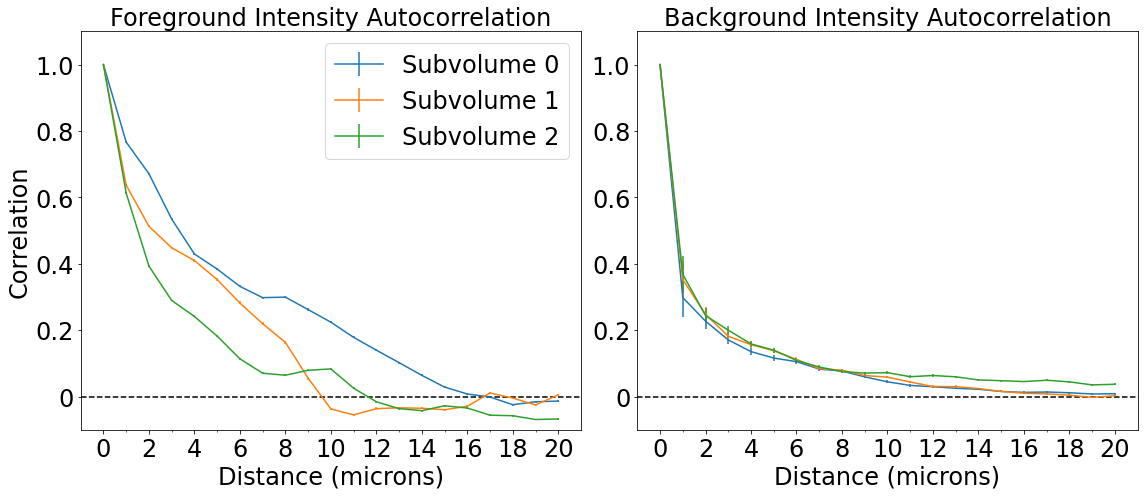

In [4]:
fig, axs = plt.subplots(1, 2)
ax_fg = axs[0]
ax_bg = axs[1]

min_cor = np.amin(data[:, :, 0, :])

for i in range(10, 13):
    for val, type in zip([1, 2], ["Background", "Foreground"]):
        cor = data[i - 10, val - 1, 0, :]
        errors = data[i - 10, val - 1, 1:, :]
        if val == 1:
            ax_bg.errorbar(
                np.arange(0, 21, 1), cor, yerr=errors, label=f"Subvolume {i-10}"
            )
        else:
            ax_fg.errorbar(
                np.arange(0, 21, 1), cor, yerr=errors, label=f"Subvolume {i-10}"
            )

min_y = round(min_cor, 1)
if min_y > min_cor:
    min_y -= 0.1

# y axis
ax_fg.set_ylim([min_y, 1.1])
ax_fg.set_yticks(np.arange(0, 1.2, 0.2))
ax_fg.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontdict={"fontsize": 24})
ax_fg.set_ylabel("Correlation", fontsize=24)

# x axis
ax_fg.set_xlabel("Distance (microns)", fontsize=24)
ax_fg.set_xlim([-1, 21])
ax_fg.set_xticks(np.arange(0, 22, 2), minor=False)
ax_fg.set_xticks(np.arange(1, 21, 2), minor=True)
ax_fg.set_xticklabels(np.arange(0, 22, 2), fontdict={"fontsize": 24})

# other
ax_fg.set_title(f"Foreground Intensity Autocorrelation", fontsize=24)
ax_fg.legend(prop={"size": 24})
ax_fg.axhline(0, linestyle="--", color="k")  # horizontal lines

# y axis
ax_bg.set_ylim([min_y, 1.1])
ax_bg.set_yticks(np.arange(0, 1.2, 0.2))
ax_bg.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontdict={"fontsize": 24})

# x axis
ax_bg.set_xlabel("Distance (microns)", fontsize=24)
ax_bg.set_xlim([-1, 21])
ax_bg.set_xticks(np.arange(0, 22, 2), minor=False)
ax_bg.set_xticks(np.arange(1, 21, 2), minor=True)
ax_bg.set_xticklabels(np.arange(0, 22, 2), fontdict={"fontsize": 24})

# other
ax_bg.set_title(f"Background Intensity Autocorrelation", fontsize=24)
ax_bg.axhline(0, linestyle="--", color="k")  # horizontal lines

fig.set_figheight(7)
fig.set_figwidth(16)
fig.tight_layout()